In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
pd.set_option('display.max_rows', 500)

In [2]:
files = glob.glob("../data/*.npz")
files = [x for x in files if "Kitsune" not in x]


datasets = []

for d in files: 
    data = np.load(d)
    X, y = data['X'], data['y']
    datasets.append((d, X.shape))
interesting_datasets = [fn[0].split("/")[-1] for fn in sorted(datasets, key=lambda x: x[1][0] * x[1][1])[-12:]]
print(interesting_datasets)



['25_musk.npz', '16_http.npz', '24_mnist.npz', '1_ALOI.npz', '36_speech.npz', '5_campaign.npz', '10_cover.npz', '17_InternetAds.npz', '8_celeba.npz', '13_fraud.npz', '3_backdoor.npz', '9_census.npz']


# General overview

Let's get a general overview over the quality of the individual methods:

In [3]:
# roc_df = roc_df[roc_df.dataset.isin(interesting_datasets)]
df = pd.read_csv('../results/results_whitebox_with_repetitions.csv')
df = df[df.dataset.isin(interesting_datasets)]
baseline_df = pd.read_csv('../results/results_baselines.csv')
baseline_df = baseline_df[baseline_df.dataset.isin(interesting_datasets)]
blackbox_df = pd.read_csv('../results/results_blackbox_with_repetitions.csv')
blackbox_df = blackbox_df[blackbox_df.dataset.isin(interesting_datasets)]

df['time'] = df['time_build'] + df['time_detect']
blackbox_df['time'] = blackbox_df['time_build'] + blackbox_df['time_detect']

# Separate BlackBox into KNN and LOF methods
BB_KNN_df = blackbox_df[blackbox_df.variant == 'KNN']
BB_LOF_df = blackbox_df[blackbox_df.variant == 'LOF']

# Taking max AUCROC value over all parameter choices in whitebox and blackbox HNSW.
# Note blackbox has multiple runs, so a mean is computed first.
whitebox_df = df[["dataset", "variant", "ROCAUC"]].groupby(['dataset', "variant"]).max().pivot_table(index="dataset", columns="variant", values=["ROCAUC"])
BB_KNN_df = BB_KNN_df[["dataset", "M", "ef_c", "ef_s", "k", "variant", "ROCAUC"]].groupby(['dataset', "M", "ef_c", "ef_s", "k", "variant"]).mean().groupby(['dataset', "k", "variant"]).max()
BB_LOF_df = BB_LOF_df[["dataset", "M", "ef_c", "ef_s", "k", "variant", "ROCAUC"]].groupby(['dataset', "M", "ef_c", "ef_s", "k", "variant"]).mean().groupby(['dataset', "k", "variant"]).max()


BB_KNN_df['hnsw_blackbox'] = 'BlackBox KNN'
BB_KNN_df = BB_KNN_df.set_index('hnsw_blackbox', append=True).unstack('hnsw_blackbox')
BB_LOF_df['hnsw_blackbox'] = 'BlackBox LOF'
BB_LOF_df = BB_LOF_df.set_index('hnsw_blackbox', append=True).unstack('hnsw_blackbox')

In [4]:
# blackbox_df = pd.read_csv('../results/results_blackbox.csv')
# blackbox_df = blackbox_df[blackbox_df.dataset.isin(interesting_datasets)]
# blackbox_df = blackbox_df[["dataset", "M", "ef_c", "ef_s", "k", "ROCAUC"]].groupby(['dataset', "M", "ef_c", "ef_s", "k"]).mean().groupby(['dataset', "k"]).max()
# blackbox_df = blackbox_df[["dataset", "k", "ROCAUC"]].groupby(['dataset', "k"]).max()
# blackbox_df

In [5]:
quality_df = baseline_df.pivot_table(index=["dataset", "k"], columns="variant", values = ["ROCAUC", "time"]).reset_index()
#level_one = quality_df.columns.get_level_values(0).astype(str)
#level_two = quality_df.columns.get_level_values(1).astype(str)
#quality_df.columns = level_one + level_two

In [6]:
res = quality_df.merge(whitebox_df, on="dataset").merge(BB_KNN_df, on=['dataset', 'k']).merge(BB_LOF_df, on=['dataset', 'k'])
res[res.k == 15]

dataset   k    ROCAUC                            time   
                                 KNN       LOF      ODIN         KNN   
0         10_cover.npz  15  0.855119  0.560195  0.523428    5.573199  \
4         13_fraud.npz  15  0.960832  0.486456  0.590600   14.384666   
8          16_http.npz  15  0.997881  0.671817  0.512416    3.087932   
12  17_InternetAds.npz  15  0.720609  0.626229  0.531636    0.319053   
16          1_ALOI.npz  15  0.639548  0.756739  0.782615    1.184035   
20        24_mnist.npz  15  0.829698  0.622201  0.606480    0.179667   
24         25_musk.npz  15  0.787528  0.413032  0.491845    0.113553   
28       36_speech.npz  15  0.479276  0.522216  0.652570    0.174751   
32      3_backdoor.npz  15  0.755307  0.702600  0.566977    7.487091   
36      5_campaign.npz  15  0.727270  0.517294  0.625612    1.552443   
40        8_celeba.npz  15  0.544126  0.445239  0.445359    3.395435   
44        9_census.npz  15  0.516312  0.505402  0.513954  101.414314   

                                 ROCAUC                              
          LOF       ODIN contrast=False contrast=True BlackBox KNN   
0    5.743242   7.477732       0.730754      0.493273     0.857170  \
4   13.490795  15.027909       0.889606      0.612410     0.960369   
8    3.170544   4.506666       0.988970      0.574186     0.995953   
12   0.225346   0.207259       0.832738      0.610267     0.746328   
16   2.147117   1.447858       0.835649      0.898335     0.665388   
20   0.098605   0.251564       0.681500      0.563485     0.818570   
24   0.046853   0.108935       0.711573      0.433313     1.000000   
28   0.077363   0.162172       0.943851      0.834537     0.502847   
32   6.506582   6.334617       0.827159      0.602067     0.768211   
36   1.160252   1.505559       0.632243      0.523114     0.685222   
40   2.786049   3.534438       0.562608      0.523918     0.547602   
44  92.765149  97.835460       0.512570      0.487972     0.509457   

                 
   BlackBox LOF  
0      0.566431  
4      0.765377  
8      0.868868  
12     0.747599  
16     0.752170  
20     0.693618  
24     1.000000  
28     0.517073  
32     0.778920  
36     0.517290  
40     0.480106  
44     0.505017

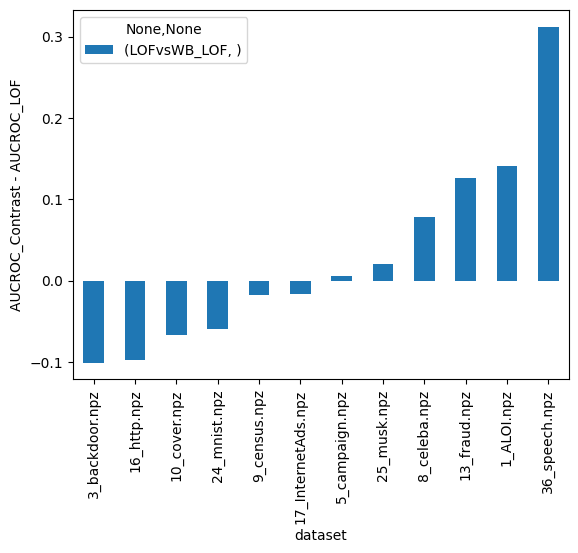

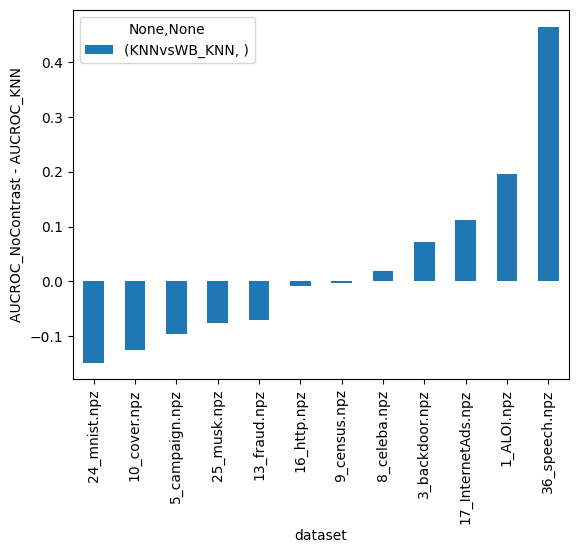

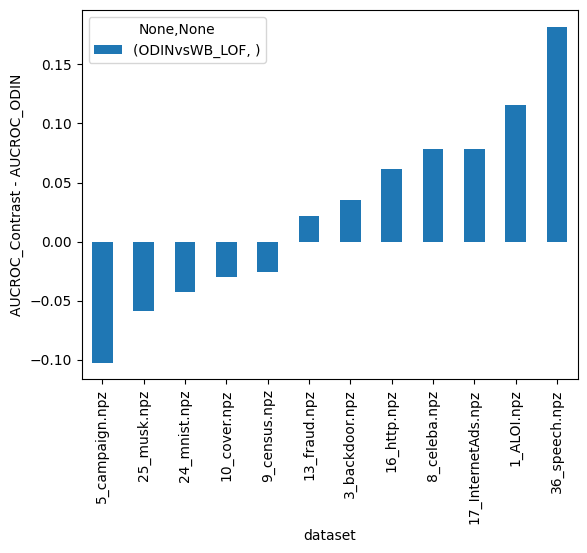

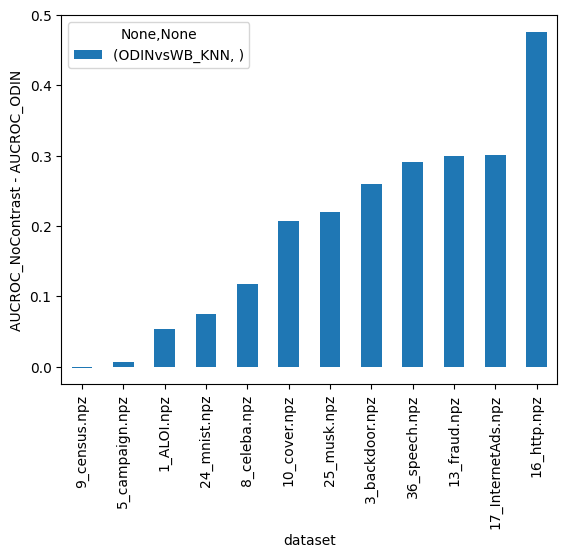

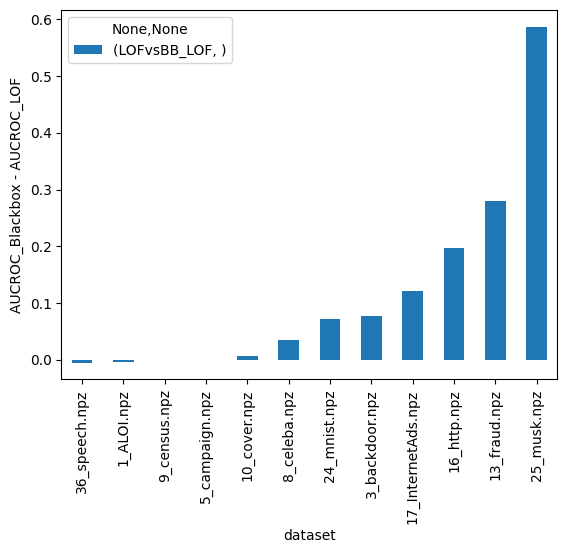

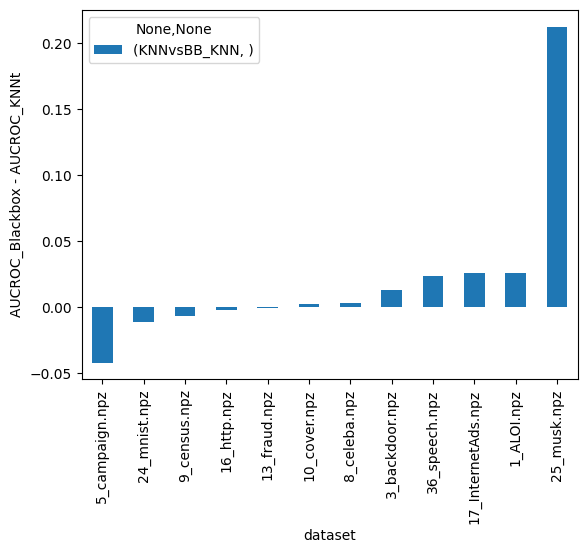

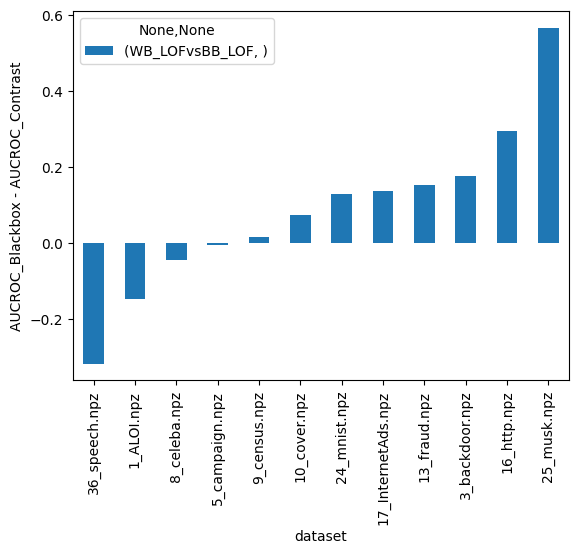

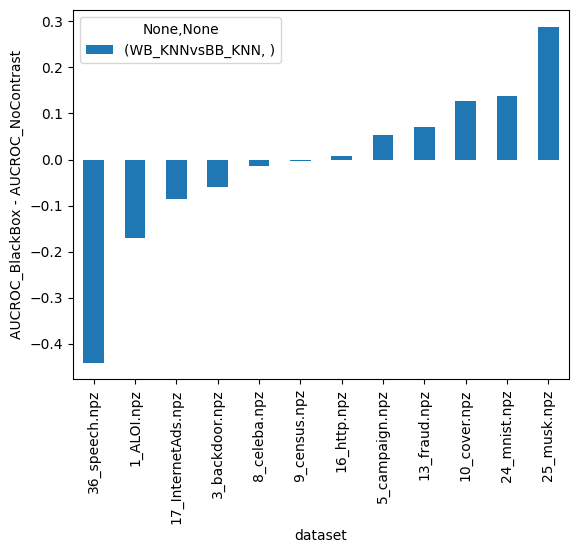

In [7]:
res['LOFvsWB_LOF'] = res['ROCAUC']['contrast=True'] - res['ROCAUC']['LOF']
res['KNNvsWB_KNN'] = res['ROCAUC']['contrast=False'] - res['ROCAUC']['KNN']
res['ODINvsWB_LOF'] = res['ROCAUC']['contrast=True'] - res['ROCAUC']['ODIN']
res['ODINvsWB_KNN'] = res['ROCAUC']['contrast=False'] - res['ROCAUC']['ODIN']
res['LOFvsBB_LOF'] = res['ROCAUC']['BlackBox LOF'] - res['ROCAUC']['LOF']
res['KNNvsBB_KNN'] = res['ROCAUC']['BlackBox KNN'] - res['ROCAUC']['KNN']
res['WB_LOFvsBB_LOF'] = res['ROCAUC']['BlackBox LOF'] - res['ROCAUC']['contrast=True']
res['WB_KNNvsBB_KNN'] = res['ROCAUC']['BlackBox KNN'] - res['ROCAUC']['contrast=False']

labels = ['LOFvsWB_LOF', 
          'KNNvsWB_KNN', 
          'ODINvsWB_LOF', 
          'ODINvsWB_KNN', 
          'LOFvsBB_LOF', 
          'KNNvsBB_KNN', 
          'WB_LOFvsBB_LOF', 
          'WB_KNNvsBB_KNN']

method = ['AUCROC_Contrast - AUCROC_LOF', 
          'AUCROC_NoContrast - AUCROC_KNN', 
          'AUCROC_Contrast - AUCROC_ODIN', 
          'AUCROC_NoContrast - AUCROC_ODIN', 
          'AUCROC_Blackbox - AUCROC_LOF', 
          'AUCROC_Blackbox - AUCROC_KNNt', 
          'AUCROC_Blackbox - AUCROC_Contrast', 
          'AUCROC_BlackBox - AUCROC_NoContrast']

#res[['dataset', 'ROCAUC']]
i = 0
for x in labels:
    barPlot = res[res.k == 15][['dataset', x]].sort_values(x).plot.bar(x='dataset')
    barPlot.set_ylabel(method[i])
    i += 1

In [8]:
res.describe()

k     ROCAUC                              time              
                         KNN        LOF       ODIN         KNN        LOF   
count   48.000000  48.000000  48.000000  48.000000   48.000000  48.000000  \
mean    48.750000   0.746572   0.603573   0.589333   12.772315  11.348860   
std     32.428317   0.173945   0.137782   0.104048   28.878384  24.898028   
min     15.000000   0.478689   0.373290   0.441808    0.081982   0.046853   
25%     26.250000   0.569941   0.491960   0.513570    0.309825   0.163759   
50%     40.000000   0.741288   0.582804   0.581972    3.199166   2.956347   
75%     62.500000   0.886337   0.699830   0.636600    7.718328   6.958963   
max    100.000000   1.000000   0.999653   0.994210  114.850242  94.889139   

                          ROCAUC                                           
             ODIN contrast=False contrast=True BlackBox KNN BlackBox LOF   
count   48.000000      48.000000     48.000000    48.000000    48.000000  \
mean    13.349652       0.762435      0.596406     0.755791     0.700856   
std     26.468656       0.144207      0.133543     0.179138     0.174379   
min      0.108935       0.512570      0.433313     0.484365     0.470755   
25%      0.303110       0.669186      0.515654     0.584612     0.517235   
50%      4.140875       0.778957      0.568836     0.757270     0.729470   
75%      9.824011       0.849138      0.610803     0.919827     0.818145   
max    101.721044       0.988970      0.898335     1.000000     1.000000   

      LOFvsWB_LOF KNNvsWB_KNN ODINvsWB_LOF ODINvsWB_KNN LOFvsBB_LOF   
                                                                      
count   48.000000   48.000000    48.000000    48.000000   48.000000  \
mean    -0.007167    0.015863     0.007074     0.173102    0.097282   
std      0.164819    0.183591     0.115640     0.137449    0.168861   
min     -0.425467   -0.288427    -0.420024    -0.058195   -0.005143   
25%     -0.091471   -0.094496    -0.056144     0.048627   -0.000422   
50%     -0.016696   -0.008925     0.006609     0.190610    0.014063   
75%      0.074189    0.081921     0.078577     0.286321    0.088500   
max      0.355034    0.465162     0.239349     0.476554    0.626710   

      KNNvsBB_KNN WB_LOFvsBB_LOF WB_KNNvsBB_KNN  
                                                 
count   48.000000      48.000000      48.000000  
mean     0.009219       0.104449      -0.006644  
std      0.039156       0.231540       0.185009  
min     -0.042096      -0.352215      -0.459486  
25%     -0.004849      -0.020451      -0.065813  
50%      0.001339       0.104676       0.007073  
75%      0.011691       0.215899       0.085690  
max      0.212472       0.566687       0.288427

In [9]:
res[res.k == 15][["k", 'ROCAUC']].describe()

k     ROCAUC                                                      
                   KNN        LOF       ODIN contrast=False contrast=True   
count  12.0  12.000000  12.000000  12.000000      12.000000     12.000000  \
mean   15.0   0.734459   0.569118   0.570291       0.762435      0.596406   
std     0.0   0.166706   0.106691   0.089757       0.149042      0.138020   
min    15.0   0.479276   0.413032   0.445359       0.512570      0.433313   
25%    15.0   0.615693   0.500666   0.513570       0.669186      0.515654   
50%    15.0   0.741288   0.541206   0.549307       0.778957      0.568836   
75%    15.0   0.836053   0.637626   0.611263       0.849138      0.610803   
max    15.0   0.997881   0.756739   0.782615       0.988970      0.898335   

                                 
      BlackBox KNN BlackBox LOF  
count    12.000000    12.000000  
mean      0.754760     0.682706  
std       0.179589     0.165561  
min       0.502847     0.480106  
25%       0.635941     0.517235  
50%       0.757270     0.720608  
75%       0.882969     0.768763  
max       1.000000     1.000000

In [10]:
res = res.rename(columns={"contrast=True": "LOF-WB", "contrast=False": "KNN-WB"})
print(res)
#res = res[res.k == 15]
#res.columns = res.columns.droplevel(0)
#res.boxplot(rot=45, figsize=(6, 3), column=["KNN", "BlackBox KNN", "KNN-WB", "LOF", "BlackBox LOF", "LOF-WB",  "ODIN"])

               dataset    k    ROCAUC                            time   
                                  KNN       LOF      ODIN         KNN   
0         10_cover.npz   15  0.855119  0.560195  0.523428    5.573199  \
1         10_cover.npz   30  0.883457  0.564950  0.530677    8.401655   
2         10_cover.npz   50  0.894977  0.577834  0.549612   11.472786   
3         10_cover.npz  100  0.904012  0.582690  0.573344   18.141685   
4         13_fraud.npz   15  0.960832  0.486456  0.590600   14.384666   
5         13_fraud.npz   30  0.960690  0.472937  0.600756   14.646178   
6         13_fraud.npz   50  0.960416  0.496127  0.599413   14.892933   
7         13_fraud.npz  100  0.958888  0.582918  0.607750   16.628579   
8          16_http.npz   15  0.997881  0.671817  0.512416    3.087932   
9          16_http.npz   30  0.999634  0.643612  0.565628    3.942541   
10         16_http.npz   50  0.999835  0.914867  0.530416    5.066955   
11         16_http.npz  100  0.999589  0.999653  0.

#  Critical Difference Plot

In [11]:
baseline_df = pd.read_csv('../results/results_baselines.csv')
wb_df = pd.read_csv('../results/results_whitebox_with_repetitions.csv')
bb_df = pd.read_csv('../results/results_blackbox_with_repetitions.csv')


base = baseline_df.pivot_table(index=["dataset", "k", "variant"], values = ["ROCAUC"]).reset_index()

# take median ROCAUC value for each parameter choice
wb_df = df.groupby(["dataset", "variant", "M", "ef"]).mean().reset_index()
wb_df = wb_df.groupby(["dataset", "variant"]).mean().reset_index()
bb_df = bb_df.groupby(["dataset", "variant", "k", "M", "ef_c", "ef_s"]).mean().reset_index()
bb_df = bb_df[bb_df.k == 15].groupby(["dataset", "variant"]).mean().reset_index()

print(base)

indexBBLOF = bb_df[bb_df['variant'] == 'LOF'].index
for i in indexBBLOF:
    bb_df.loc[i,'variant'] = 'LOF-BB'

indexBBKNN = bb_df[bb_df['variant'] == 'KNN'].index
for i in indexBBKNN:
    bb_df.loc[i,'variant'] = 'KNN-BB'

#print(whitebox_df)

indexWBLOF = wb_df[wb_df['variant'] == 'contrast=True'].index
for i in indexWBLOF:
    wb_df.loc[i,'variant'] = 'LOF-WB'

indexWBKNN = wb_df[wb_df['variant'] == 'contrast=False'].index
for i in indexWBKNN:
    wb_df.loc[i,'variant'] = 'KNN-WB'

          dataset    k variant    ROCAUC
0    10_cover.npz   15     KNN  0.855119
1    10_cover.npz   15     LOF  0.560195
2    10_cover.npz   15    ODIN  0.523428
3    10_cover.npz   30     KNN  0.883457
4    10_cover.npz   30     LOF  0.564950
..            ...  ...     ...       ...
556  9_census.npz   50     LOF  0.492444
557  9_census.npz   50    ODIN  0.506915
558  9_census.npz  100     KNN  0.514115
559  9_census.npz  100     LOF  0.471288
560  9_census.npz  100    ODIN  0.502764

[561 rows x 4 columns]


In [ ]:
frames = [base[base.k == 15], wb_df, bb_df]
temp = pd.concat(frames)

# Save dataframe as csv file
csvfile = temp[["dataset", "variant", "ROCAUC"]].sort_values(by=['dataset', 'variant'])
csvfile.to_csv("critddiagram.csv", ",")

In [ ]:
from critdd import Diagram

cd = pd.read_csv("critddiagram.csv").pivot(
    index = "dataset",
    columns = "variant",
    values = "ROCAUC"
)
# create a CD diagram from the Pandas DataFrame
diagram = Diagram(
    cd.to_numpy(),
    treatment_names = cd.columns,
    maximize_outcome = True
)

# inspect average ranks and groups of statistically indistinguishable treatments
diagram.average_ranks # the average rank of each treatment
diagram.get_groups(alpha=.05, adjustment="holm")

# export the diagram to a file
diagram.to_file(
    "critddiagram.tex",
    alpha = .05,
    adjustment = "holm",
    reverse_x = True,
    axis_options = {"title": "critdd"},
)

# Individual evaluation of the different methods

In [14]:
baseline_df = pd.read_csv('../results/results_baselines.csv')
baseline_df = baseline_df[baseline_df.dataset.isin(interesting_datasets)]

# Heatmaps

In [15]:
norm = mpl.colors.Normalize(-0.3, 0.3)

#colors = [[norm([-0.3]), "black"], 
#          [norm([-0.2]), "purple"], 
#          [norm([-0.1]), "blue"], 
#          [norm([0]), "green"],
#          [norm([0.1]), "yellow"],
#          [norm([0.2]), "orange"],
#          [norm([0.3]), "red"]
#          ]
colors = [[norm([-0.3]), "black"], 
          [norm([-0.2]), "navy"], 
          [norm([-0.1]), sns.color_palette("colorblind")[0]], 
          [norm([0]), sns.color_palette("colorblind")[2]],
          [norm([0.1]), "yellowgreen"],
          [norm([0.2]), sns.color_palette("colorblind")[1]],
          [norm([0.3]), sns.color_palette("colorblind")[8]]
          ]


custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# HNSW (blackbox)

See blackbox.py for individual parameter ranges.

In [16]:
blackbox_df = pd.read_csv('../results/results_blackbox_with_repetitions.csv')
blackbox_df = blackbox_df[blackbox_df.dataset.isin(interesting_datasets)]
blackbox_df['time'] = blackbox_df['time_build'] + blackbox_df['time_detect']

## BlackBox LOF

In [17]:
eval_BBLOF_df = blackbox_df[blackbox_df.variant == 'LOF'].merge(baseline_df[baseline_df.variant == 'LOF'], on=['dataset', 'k'])
eval_BBLOF_df['ROCAUC_diff'] = eval_BBLOF_df['ROCAUC_x'] - eval_BBLOF_df['ROCAUC_y']
eval_BBLOF_df

,dataset,M,variant_x,ef_c,ef_s,k,ROCAUC_x,run,time_build,time_detect,time_x,variant_y,ROCAUC_y,time_y,ROCAUC_diff
0,25_musk.npz,8,LOF,10,8,15,1.000000,0,0.023859,0.020512,0.044370,LOF,0.413032,0.046853,0.586968
1,25_musk.npz,8,LOF,10,16,15,1.000000,0,0.023859,0.006990,0.030849,LOF,0.413032,0.046853,0.586968
2,25_musk.npz,8,LOF,10,32,15,1.000000,0,0.023859,0.009665,0.033524,LOF,0.413032,0.046853,0.586968
3,25_musk.npz,8,LOF,10,48,15,1.000000,0,0.023859,0.007139,0.030998,LOF,0.413032,0.046853,0.586968
4,25_musk.npz,8,LOF,10,64,15,1.000000,0,0.023859,0.008096,0.031955,LOF,0.413032,0.046853,0.586968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46075,9_census.npz,48,LOF,200,16,100,0.469339,9,10.765993,7.818921,18.584914,LOF,0.471288,94.159374,-0.001949
46076,9_census.npz,48,LOF,200,32,100,0.469339,9,10.765993,7.799427,18.565421,LOF,0.471288,94.159374,-0.001949
46077,9_census.npz,48,LOF,200,48,100,0.469339,9,10.765993,7.660914,18.426908,LOF,0.471288,94.159374,-0.001949
46078,9_census.npz,48,LOF,200,64,100,0.469339,9,10.765993,7.668718,18.434711,LOF,0.471288,94.159374,-0.001949


[0.00976892 0.00976892 0.00963033 0.00963033 0.00934789]
[0.00257537 0.00257537 0.00174253 0.00173159 0.00173159]
[0.0008539  0.0008539  0.00040994 0.00036121 0.00036121]
[0.00093106 0.0007657  0.0007657  0.00075294 0.00068069]
[0.0004464  0.0004464  0.00033057 0.00033057 0.0002347 ]
[0.01129133 0.01129133 0.01127938 0.01127492 0.01127333]
[0.04158363 0.04158363 0.03977704 0.03977704 0.03649766]
[0.00035732 0.00035732 0.00018438 0.00018438 0.00017327]
[0.00091589 0.00091589 0.00073691 0.00073691 0.00071809]
[0.00031426 0.00031426 0.00030555 0.00030555 0.00027891]
[0.00843872 0.00843872 0.00805774 0.00653221 0.00543779]
[0.00232794 0.00232794 0.00227457 0.00225974 0.00216866]


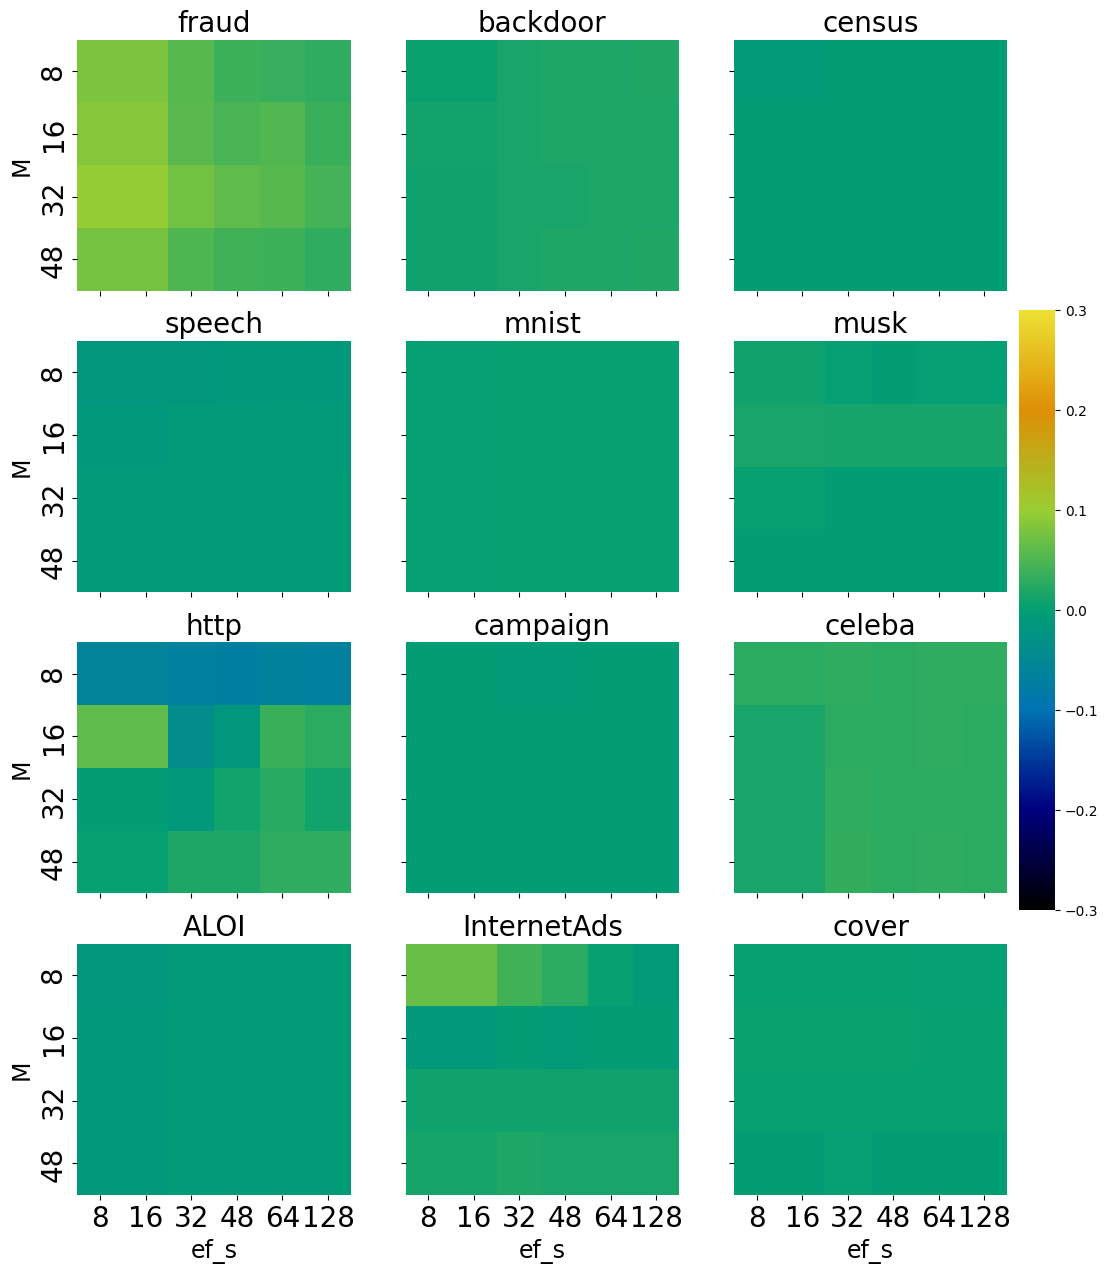

In [18]:
K = 15
EF_C = 100

# Define the bound
upper_bound = 0.05


plot_df = eval_BBLOF_df[(eval_BBLOF_df.dataset.isin(interesting_datasets)) & (eval_BBLOF_df.k == K) & (eval_BBLOF_df.ef_c == EF_C)]
f, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12, 15))
cbar_ax = f.add_axes([.91, .3, 0.03, .4])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        for ef_c in sorted(set(plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]['ef_c'].values)):
            to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k) & (plot_df.ef_c == ef_c)]
            AUCROC_means = to_plot[['M', 'ef_s', 'ROCAUC_diff']].pivot_table(index="M", columns="ef_s", values="ROCAUC_diff")
            sem = to_plot[['M', 'ef_s', 'ROCAUC_diff']].pivot_table(index="M", columns="ef_s", values="ROCAUC_diff", aggfunc='sem')
            # Inspect instance of highest variance
            print(np.sort(np.partition(np.asarray(sem), sem.size - 5, axis=None)[-5:])[::-1])
            # Remove instances of too high variance
            # AUCROC_means[(sem > upper_bound)] = np.nan
            sns.heatmap(AUCROC_means, vmax=0.3, vmin=-0.3, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 11, cbar_ax=None if i != 11 else cbar_ax)
            
            
            # Set axis titles and font sizes for bottom row
            axes.flat[i].set_title(f"{dataset.split('_')[1].split('.')[0]}", fontsize=20) # , k={k}, ef_c = {ef_c}

            if i > 8:
                axes.flat[i].set_xlabel("ef_s", fontsize=17)
            else:
                axes.flat[i].set_xlabel("", fontsize=17)
                
            if i%3 == 0:
                axes.flat[i].set_ylabel("M", fontsize=17)
            else:
                axes.flat[i].set_ylabel("", fontsize=17)

            
            # Set tick label font size
            axes.flat[i].tick_params(axis='both', which='major', labelsize=20)

#cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
#plt.colorbar(axes.flat[-1], 
#             cax=cax, 
#             **kw)
plt.show()

## BlackBox KNN

In [19]:
eval_BBKNN_df = blackbox_df[blackbox_df.variant == 'KNN'].merge(baseline_df[baseline_df.variant == 'KNN'], on=['dataset', 'k'])
eval_BBKNN_df['ROCAUC_diff'] = eval_BBKNN_df['ROCAUC_x'] - eval_BBKNN_df['ROCAUC_y']
eval_BBKNN_df

,dataset,M,variant_x,ef_c,ef_s,k,ROCAUC_x,run,time_build,time_detect,time_x,variant_y,ROCAUC_y,time_y,ROCAUC_diff
0,25_musk.npz,8,KNN,10,8,15,1.000000,0,0.023859,0.020512,0.044370,KNN,0.787528,0.113553,0.212472
1,25_musk.npz,8,KNN,10,16,15,1.000000,0,0.023859,0.006990,0.030849,KNN,0.787528,0.113553,0.212472
2,25_musk.npz,8,KNN,10,32,15,1.000000,0,0.023859,0.009665,0.033524,KNN,0.787528,0.113553,0.212472
3,25_musk.npz,8,KNN,10,48,15,1.000000,0,0.023859,0.007139,0.030998,KNN,0.787528,0.113553,0.212472
4,25_musk.npz,8,KNN,10,64,15,1.000000,0,0.023859,0.008096,0.031955,KNN,0.787528,0.113553,0.212472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46075,9_census.npz,48,KNN,200,16,100,0.508710,9,10.765993,7.818921,18.584914,KNN,0.514115,107.148280,-0.005405
46076,9_census.npz,48,KNN,200,32,100,0.508710,9,10.765993,7.799427,18.565421,KNN,0.514115,107.148280,-0.005405
46077,9_census.npz,48,KNN,200,48,100,0.508710,9,10.765993,7.660914,18.426908,KNN,0.514115,107.148280,-0.005405
46078,9_census.npz,48,KNN,200,64,100,0.508710,9,10.765993,7.668718,18.434711,KNN,0.514115,107.148280,-0.005405


[0.0006566  0.0006566  0.00053059 0.00050671 0.00045338]
[0.00292168 0.00292168 0.00235198 0.00235198 0.00212512]
[0.00040803 0.00040803 0.00026458 0.00025628 0.00025628]
[0.00120401 0.00105111 0.00102929 0.00098611 0.00091001]
[3.52644517e-05 3.52644517e-05 2.83738859e-05 2.83738859e-05
 2.13535799e-05]
[0.0124479  0.0124479  0.01205122 0.01204974 0.01204685]
[0.00065922 0.00065922 0.00058068 0.00058068 0.00056767]
[1.46296779e-04 1.46296779e-04 9.82296167e-05 5.06426233e-05
 2.85196048e-05]
[3.08628900e-05 3.08628900e-05 1.70529432e-05 7.40985731e-06
 6.88989390e-06]
[9.30058095e-05 9.30058095e-05 7.41355098e-05 7.41355098e-05
 5.89473677e-05]
[0.00229912 0.00229912 0.0021162  0.0021162  0.00204827]
[0.00425611 0.00425611 0.00412447 0.00409809 0.00408165]


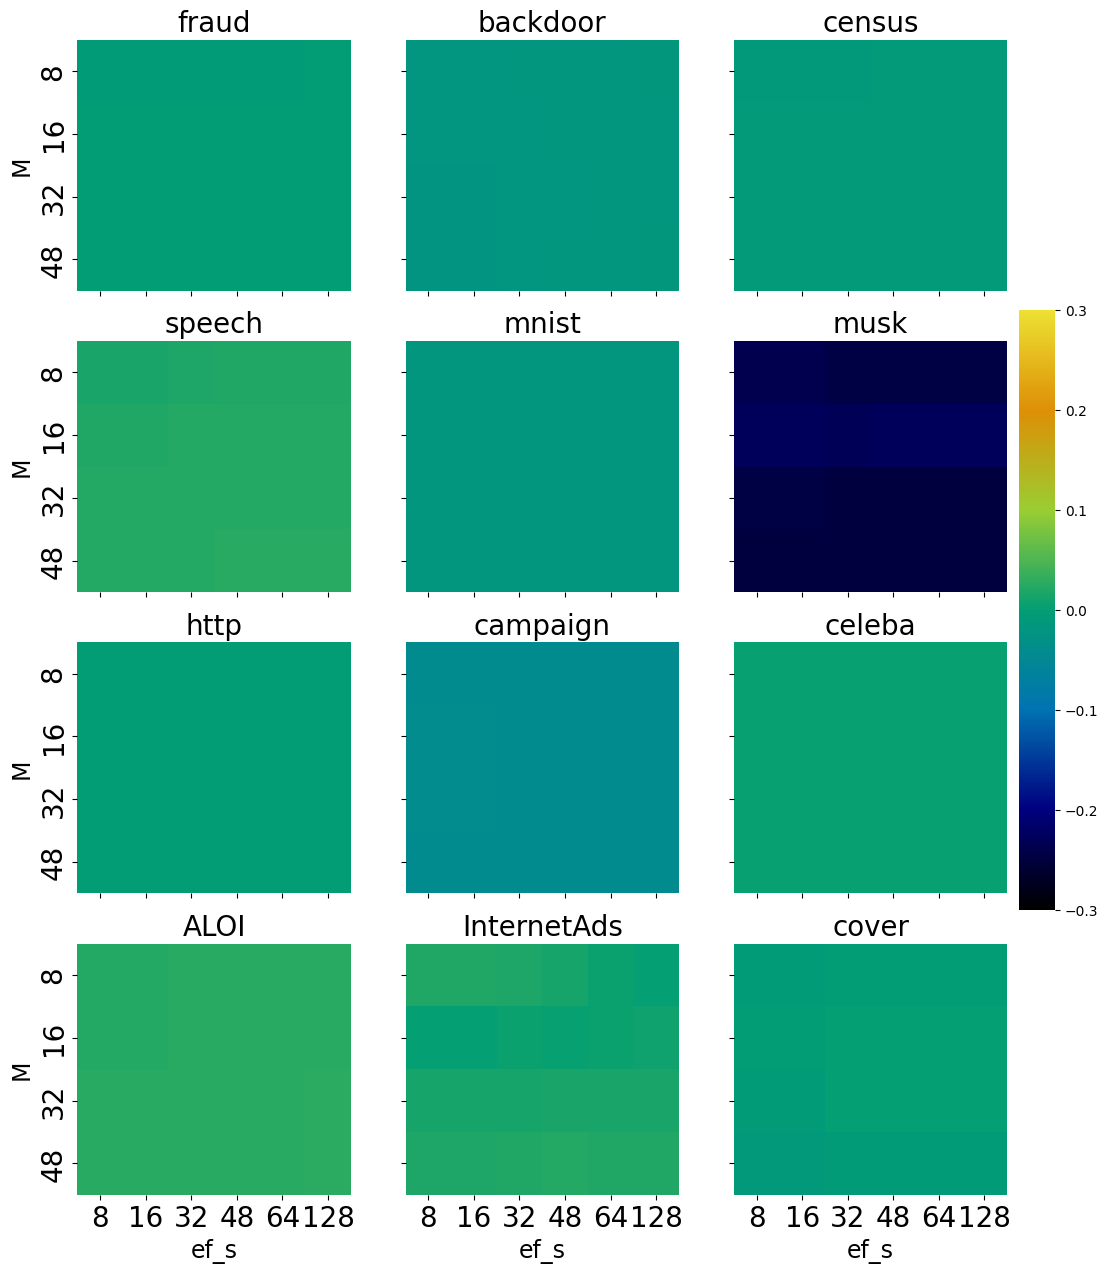

In [20]:
# eval_df[['dataset', 'M', 'ef_c', 'ef_s', 'k', 'ROCAUC_diff']]

K = 15
EF_C = 100

# Define the bound
upper_bound = 0.05


plot_df = eval_BBKNN_df[(eval_BBKNN_df.dataset.isin(interesting_datasets)) & (eval_BBKNN_df.k == K) & (eval_BBKNN_df.ef_c == EF_C)]
f, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12, 15))
cbar_ax = f.add_axes([.91, .3, 0.03, .4])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        for ef_c in sorted(set(plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]['ef_c'].values)):
            to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k) & (plot_df.ef_c == ef_c)]
            AUCROC_means = to_plot[['M', 'ef_s', 'ROCAUC_diff']].pivot_table(index="M", columns="ef_s", values="ROCAUC_diff")
            # print(dataset, np.max(AUCROC_means), np.min(AUCROC_means))
            sem = to_plot[['M', 'ef_s', 'ROCAUC_diff']].pivot_table(index="M", columns="ef_s", values="ROCAUC_diff", aggfunc='sem')
            # Inspect instance of highest variance
            print(np.sort(np.partition(np.asarray(sem), sem.size - 5, axis=None)[-5:])[::-1])
            # Remove instances of too high variance
            # AUCROC_means[(sem > upper_bound)] = np.nan
            sns.heatmap(AUCROC_means, vmax=0.3, vmin=-0.3, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 11, cbar_ax=None if i != 11 else cbar_ax)
            
            
            # Set axis titles and font sizes for bottom row
            axes.flat[i].set_title(f"{dataset.split('_')[1].split('.')[0]}", fontsize=20) # , k={k}, ef_c = {ef_c}
            
            if i > 8:
                axes.flat[i].set_xlabel("ef_s", fontsize=17)
            else:
                axes.flat[i].set_xlabel("", fontsize=17)
                
            if i%3 == 0:
                axes.flat[i].set_ylabel("M", fontsize=17)
            else:
                axes.flat[i].set_ylabel("", fontsize=17)

            # Set tick label font size
            axes.flat[i].tick_params(axis='both', which='major', labelsize=20)

plt.show()

# HNSW (whitebox)

In [21]:
whitebox_df = pd.read_csv('../results/results_whitebox_with_repetitions.csv')
whitebox_df = whitebox_df[whitebox_df.dataset.isin(interesting_datasets)]
whitebox_df['time'] = whitebox_df['time_build'] + whitebox_df['time_detect']

## Whitebox KNN

In [22]:
eval_WBKNN_df = whitebox_df[whitebox_df.variant == 'contrast=False'].merge(baseline_df[baseline_df.variant == 'KNN'], on=['dataset'])
eval_WBKNN_df['ROCAUC_diff'] = eval_WBKNN_df['ROCAUC_x'] - eval_WBKNN_df['ROCAUC_y']
eval_WBKNN_df

,dataset,M,ef,variant_x,run,ROCAUC_x,time_build,time_detect,time_x,variant_y,k,ROCAUC_y,time_y,ROCAUC_diff
0,25_musk.npz,8,10,contrast=False,0,0.319379,0.020368,0.001452,0.021820,KNN,15,0.787528,0.113553,-0.468149
1,25_musk.npz,8,10,contrast=False,0,0.319379,0.020368,0.001452,0.021820,KNN,30,0.879494,0.081982,-0.560115
2,25_musk.npz,8,10,contrast=False,0,0.319379,0.020368,0.001452,0.021820,KNN,50,0.936703,0.113826,-0.617324
3,25_musk.npz,8,10,contrast=False,0,0.319379,0.020368,0.001452,0.021820,KNN,100,1.000000,0.098617,-0.680621
4,25_musk.npz,16,10,contrast=False,0,0.372358,0.014029,0.001245,0.015274,KNN,15,0.787528,0.113553,-0.415170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,9_census.npz,32,200,contrast=False,9,0.511769,10.634124,1.885433,12.519557,KNN,100,0.514115,107.148280,-0.002346
7676,9_census.npz,48,200,contrast=False,9,0.512347,10.929154,1.891153,12.820307,KNN,15,0.516312,101.414314,-0.003965
7677,9_census.npz,48,200,contrast=False,9,0.512347,10.929154,1.891153,12.820307,KNN,30,0.515670,114.850242,-0.003323
7678,9_census.npz,48,200,contrast=False,9,0.512347,10.929154,1.891153,12.820307,KNN,50,0.515250,100.773041,-0.002903


[0.01308985 0.01134533 0.01110696 0.0107408  0.01071493]
[0.00521661 0.0044737  0.00302092 0.00290274 0.002494  ]
[0.00104824 0.00068324 0.0003878  0.00036038 0.0003309 ]
[0.01274353 0.01172782 0.00927887 0.00848338 0.00820974]
[0.00301796 0.00249287 0.00218598 0.00214362 0.00204373]
[0.00878226 0.00856151 0.00811787 0.0074221  0.0067792 ]
[0.0206675  0.01935923 0.01451521 0.01060056 0.00959226]
[0.0029238  0.00265313 0.00188102 0.0015525  0.00143653]
[0.00279867 0.00276149 0.00206253 0.00206204 0.00205869]
[0.00102759 0.00069571 0.00065782 0.0005858  0.00054609]
[0.00441978 0.0038878  0.00376559 0.00368653 0.00354427]
[0.00257107 0.00256602 0.0024439  0.00216036 0.00208218]


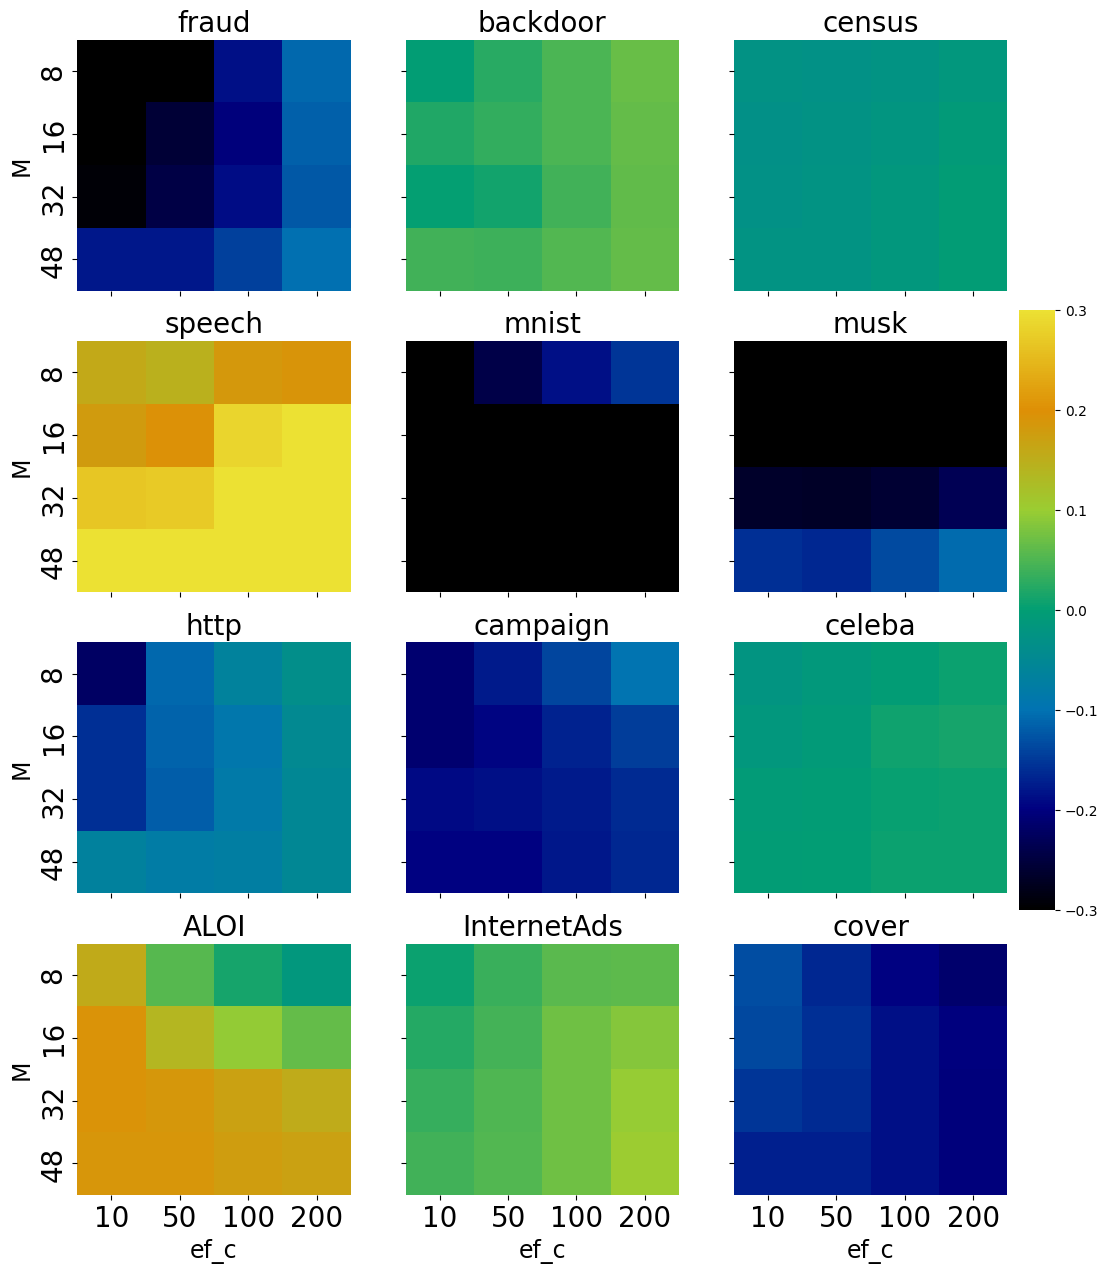

In [23]:
K = 15

# Define the bound
upper_bound = 0.05


plot_df = eval_WBKNN_df[(eval_WBKNN_df.dataset.isin(interesting_datasets)) & (eval_WBKNN_df.k == K)]
f, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12, 15))
cbar_ax = f.add_axes([.91, .3, 0.03, .4])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]
        AUCROC_means = to_plot[['M', 'ef', 'ROCAUC_diff']].pivot_table(index="M", columns="ef", values="ROCAUC_diff")
        # print(AUCROC_means)
        sem = to_plot[['M', 'ef', 'ROCAUC_diff']].pivot_table(index="M", columns="ef", values="ROCAUC_diff", aggfunc='sem')
        # Inspect instance of highest variance
        print(np.sort(np.partition(np.asarray(sem), sem.size - 5, axis=None)[-5:])[::-1])
        # Remove instances of too high variance
        # AUCROC_means[(sem > upper_bound)] = np.nan
        sns.heatmap(AUCROC_means, vmax=0.3, vmin=-0.3, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 11, cbar_ax=None if i != 11 else cbar_ax)
        
        
        # Set axis titles and font sizes for bottom row
        axes.flat[i].set_title(f"{dataset.split('_')[1].split('.')[0]}", fontsize=20) # , k={k}, ef_c = {ef_c}
        
        if i > 8:
            axes.flat[i].set_xlabel("ef_c", fontsize=17)
        else:
            axes.flat[i].set_xlabel("", fontsize=17)
            
        if i%3 == 0:
            axes.flat[i].set_ylabel("M", fontsize=17)
        else:
            axes.flat[i].set_ylabel("", fontsize=17)

        # Set tick label font size
        axes.flat[i].tick_params(axis='both', which='major', labelsize=20)


plt.show()

## Whitebox LOF

In [24]:
eval_WBLOF_df = whitebox_df[whitebox_df.variant == 'contrast=True'].merge(baseline_df[baseline_df.variant == 'LOF'], on=['dataset'])
eval_WBLOF_df['ROCAUC_diff'] = eval_WBLOF_df['ROCAUC_x'] - eval_WBLOF_df['ROCAUC_y']
eval_WBLOF_df

,dataset,M,ef,variant_x,run,ROCAUC_x,time_build,time_detect,time_x,variant_y,k,ROCAUC_y,time_y,ROCAUC_diff
0,25_musk.npz,8,10,contrast=True,0,0.355018,0.020368,0.001035,0.021404,LOF,15,0.413032,0.046853,-0.058014
1,25_musk.npz,8,10,contrast=True,0,0.355018,0.020368,0.001035,0.021404,LOF,30,0.410281,0.083752,-0.055263
2,25_musk.npz,8,10,contrast=True,0,0.355018,0.020368,0.001035,0.021404,LOF,50,0.373290,0.059474,-0.018272
3,25_musk.npz,8,10,contrast=True,0,0.355018,0.020368,0.001035,0.021404,LOF,100,0.650580,0.092642,-0.295562
4,25_musk.npz,16,10,contrast=True,0,0.313534,0.014029,0.001275,0.015304,LOF,15,0.413032,0.046853,-0.099498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,9_census.npz,32,200,contrast=True,9,0.475609,10.634124,1.910432,12.544556,LOF,100,0.471288,94.159374,0.004321
7676,9_census.npz,48,200,contrast=True,9,0.470337,10.929154,1.977386,12.906540,LOF,15,0.505402,92.765149,-0.035065
7677,9_census.npz,48,200,contrast=True,9,0.470337,10.929154,1.977386,12.906540,LOF,30,0.495095,94.889139,-0.024758
7678,9_census.npz,48,200,contrast=True,9,0.470337,10.929154,1.977386,12.906540,LOF,50,0.492444,84.179254,-0.022107


[0.00455613 0.00438274 0.00427412 0.0042132  0.00405667]
[0.00401696 0.00392623 0.00295943 0.00281382 0.0025458 ]
[0.00075205 0.00056023 0.00031763 0.00028787 0.00028656]
[0.01357637 0.01127643 0.01105945 0.00992582 0.00908077]
[0.00287238 0.0021827  0.00197218 0.00151573 0.00146397]
[0.00649709 0.00580252 0.00551998 0.00509815 0.00483654]
[0.01400509 0.01370251 0.01345776 0.01148442 0.01091943]
[0.00131882 0.0013085  0.00111392 0.00110187 0.00106088]
[0.00195527 0.00163781 0.00141059 0.00136655 0.00132285]
[0.00587132 0.00486476 0.0035556  0.00310573 0.00285523]
[0.00562034 0.00535645 0.00533882 0.00497734 0.00484416]
[0.00403233 0.00275716 0.00274119 0.00259961 0.00239657]


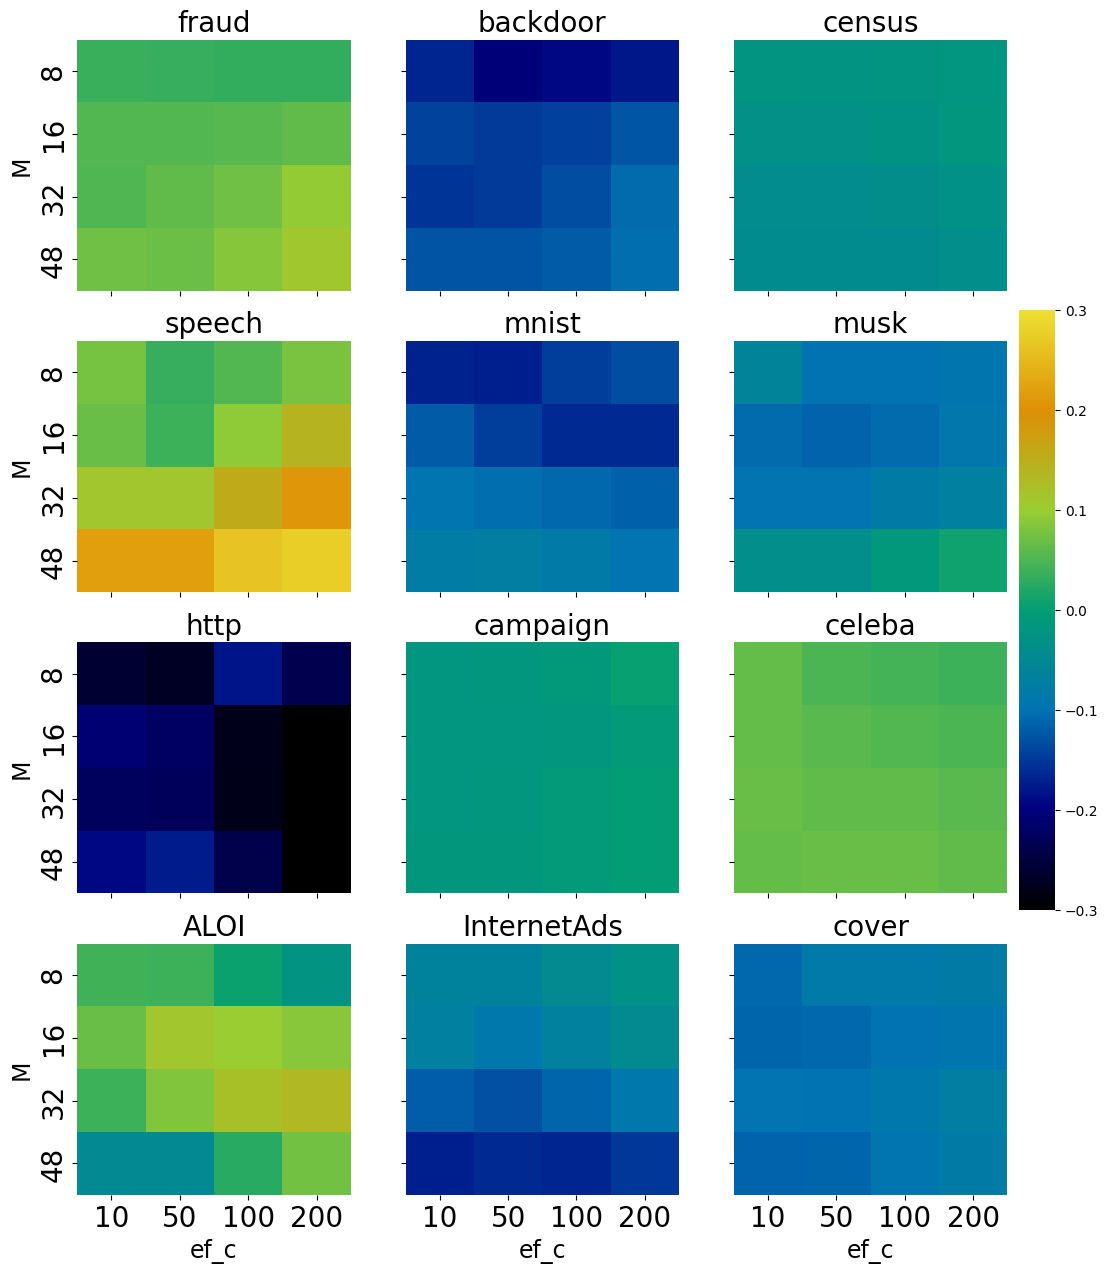

In [25]:
K = 15

# Define bound
upper_bound = 0.05


plot_df = eval_WBLOF_df[(eval_WBLOF_df.dataset.isin(interesting_datasets)) & (eval_WBLOF_df.k == K)]
f, axes = plt.subplots(nrows=4, ncols=3, sharex=True, sharey=True, figsize=(12, 15))
cbar_ax = f.add_axes([.91, .3, 0.03, .4])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]
        AUCROC_means = to_plot[['M', 'ef', 'ROCAUC_diff']].pivot_table(index="M", columns="ef", values="ROCAUC_diff")
        # print(AUCROC_means)
        sem = to_plot[['M', 'ef', 'ROCAUC_diff']].pivot_table(index="M", columns="ef", values="ROCAUC_diff", aggfunc='sem')
        # Inspect instance of highest variance
        print(np.sort(np.partition(np.asarray(sem), sem.size - 5, axis=None)[-5:])[::-1])
        # Remove instances of too high variance
        # AUCROC_means[(sem > upper_bound)] = np.nan
        sns.heatmap(AUCROC_means, vmax=0.3, vmin=-0.3, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 11, cbar_ax=None if i != 11 else cbar_ax)
        
        
        # Set axis titles and font sizes for bottom row
        axes.flat[i].set_title(f"{dataset.split('_')[1].split('.')[0]}", fontsize=20) # , k={k}, ef_c = {ef_c}
        
        if i > 8:
            axes.flat[i].set_xlabel("ef_c", fontsize=17)
        else:
            axes.flat[i].set_xlabel("", fontsize=17)
            
        if i%3 == 0:
            axes.flat[i].set_ylabel("M", fontsize=17)
        else:
            axes.flat[i].set_ylabel("", fontsize=17)

        # Set tick label font size
        axes.flat[i].tick_params(axis='both', which='major', labelsize=20)

plt.show()

# Kitsune datasets AUCROC analysis

In [26]:
kitsuneBB_df = pd.read_csv('../results/results_blackbox_kitsune.csv')
kitsuneWB_df = pd.read_csv('../results/results_whitebox_kitsune.csv')

## Blackbox

In [27]:
eval_kitsuneBBKNN_df = kitsuneBB_df[kitsuneBB_df.variant == 'KNN']
eval_kitsuneBBKNN_df[0:10]

,dataset,M,ef_c,ef_s,k,variant,ROCAUC,run,time_build,time_detect
1,Kitsune SSDP Flood_NoDup.npz,8,200,8,15,KNN,0.997257,0,30.668364,8.850313
3,Kitsune SSDP Flood_NoDup.npz,8,200,16,15,KNN,0.997257,0,30.668364,8.529761
5,Kitsune SSDP Flood_NoDup.npz,8,200,32,15,KNN,0.997364,0,30.668364,8.941575
7,Kitsune SSDP Flood_NoDup.npz,8,200,48,15,KNN,0.997418,0,30.668364,8.746670
9,Kitsune SSDP Flood_NoDup.npz,8,200,64,15,KNN,0.997431,0,30.668364,8.796968
11,Kitsune SSDP Flood_NoDup.npz,8,200,128,15,KNN,0.997448,0,30.668364,8.863242
13,Kitsune SSDP Flood_NoDup.npz,8,200,256,15,KNN,0.997446,0,30.668364,9.960248
15,Kitsune SSDP Flood_NoDup.npz,8,200,8,30,KNN,0.997393,0,30.668364,9.817666
17,Kitsune SSDP Flood_NoDup.npz,8,200,16,30,KNN,0.997393,0,30.668364,9.771233
19,Kitsune SSDP Flood_NoDup.npz,8,200,32,30,KNN,0.997399,0,30.668364,10.081400


In [28]:
eval_kitsuneBBLOF_df = kitsuneBB_df[kitsuneBB_df.variant == 'LOF']
eval_kitsuneBBLOF_df[0:10]

,dataset,M,ef_c,ef_s,k,variant,ROCAUC,run,time_build,time_detect
0,Kitsune SSDP Flood_NoDup.npz,8,200,8,15,LOF,0.602390,0,30.668364,8.850313
2,Kitsune SSDP Flood_NoDup.npz,8,200,16,15,LOF,0.602390,0,30.668364,8.529761
4,Kitsune SSDP Flood_NoDup.npz,8,200,32,15,LOF,0.574565,0,30.668364,8.941575
6,Kitsune SSDP Flood_NoDup.npz,8,200,48,15,LOF,0.556633,0,30.668364,8.746670
8,Kitsune SSDP Flood_NoDup.npz,8,200,64,15,LOF,0.548297,0,30.668364,8.796968
10,Kitsune SSDP Flood_NoDup.npz,8,200,128,15,LOF,0.541518,0,30.668364,8.863242
12,Kitsune SSDP Flood_NoDup.npz,8,200,256,15,LOF,0.541524,0,30.668364,9.960248
14,Kitsune SSDP Flood_NoDup.npz,8,200,8,30,LOF,0.594393,0,30.668364,9.817666
16,Kitsune SSDP Flood_NoDup.npz,8,200,16,30,LOF,0.594393,0,30.668364,9.771233
18,Kitsune SSDP Flood_NoDup.npz,8,200,32,30,LOF,0.592825,0,30.668364,10.081400


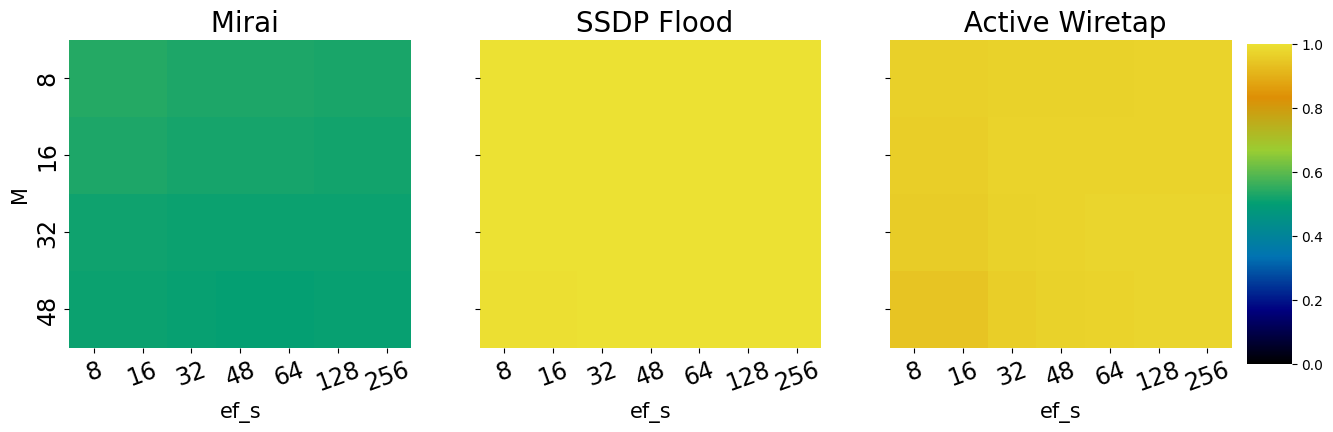

In [29]:
K = 15
EF_C = 200


plot_df = eval_kitsuneBBKNN_df[(eval_kitsuneBBKNN_df.k == K) & (eval_kitsuneBBKNN_df.ef_c == EF_C)]
f, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 4))
cbar_ax = f.add_axes([.91, 0.07, 0.03, .8])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        for ef_c in sorted(set(plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]['ef_c'].values)):
            to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k) & (plot_df.ef_c == ef_c)]
            AUCROC_means = to_plot[['M', 'ef_s', 'ROCAUC']].pivot_table(index="M", columns="ef_s", values="ROCAUC")
            # print(AUCROC_means)
            sns.heatmap(AUCROC_means, vmax=1, vmin=0, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 2, cbar_ax=None if i != 2 else cbar_ax)
            
            # Set axis titles and font sizes for bottom row
            axes.flat[i].set_title(f"{dataset.split('_')[0].split('.')[0][7:]}", fontsize=20) # , k={k}, ef_c = {ef_c}
            
            axes.flat[i].set_xlabel("ef_s", fontsize=15)
                
            if i%3 == 0:
                axes.flat[i].set_ylabel("M", fontsize=15)
            else:
                axes.flat[i].set_ylabel("")

            # Set tick label font size
            axes.flat[i].tick_params(axis='x', which='major', rotation=20, labelsize=17)
            axes.flat[i].tick_params(axis='y', which='major', labelsize=17)

plt.show()

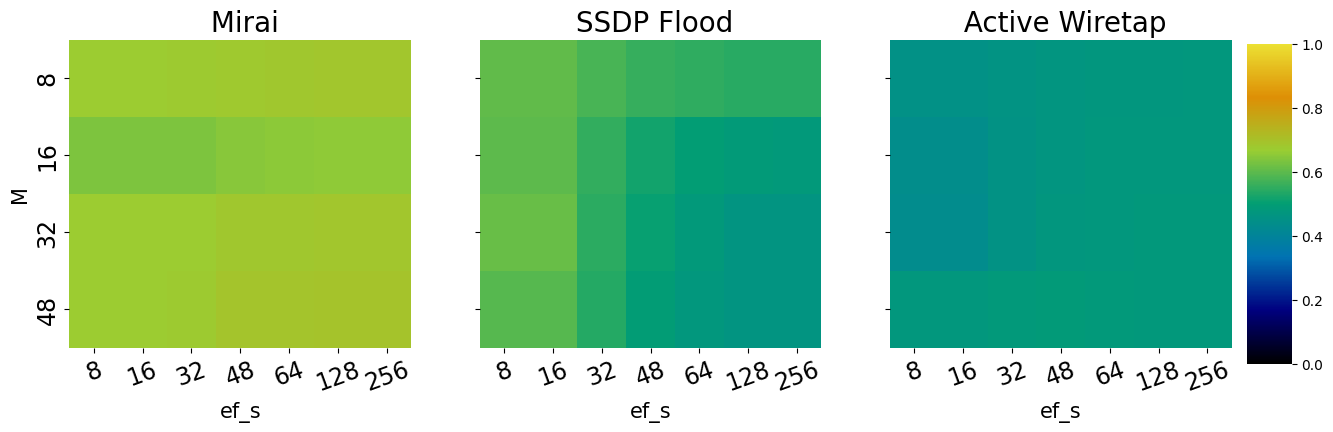

In [30]:
K = 15
EF_C = 200


plot_df = eval_kitsuneBBLOF_df[(eval_kitsuneBBLOF_df.k == K) & (eval_kitsuneBBLOF_df.ef_c == EF_C)]
f, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 4))
cbar_ax = f.add_axes([.91, 0.07, 0.03, .8])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    for k in set(plot_df[plot_df.dataset == dataset]['k'].values):
        for ef_c in sorted(set(plot_df[(plot_df.dataset == dataset) & (plot_df.k == k)]['ef_c'].values)):
            to_plot = plot_df[(plot_df.dataset == dataset) & (plot_df.k == k) & (plot_df.ef_c == ef_c)]
            AUCROC_means = to_plot[['M', 'ef_s', 'ROCAUC']].pivot_table(index="M", columns="ef_s", values="ROCAUC")
            # print(AUCROC_means)
            sns.heatmap(AUCROC_means, vmax=1, vmin=0, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 2, cbar_ax=None if i != 2 else cbar_ax)
            
            
            # Set axis titles and font sizes for bottom row
            axes.flat[i].set_title(f"{dataset.split('_')[0].split('.')[0][7:]}", fontsize=20) # , k={k}, ef_c = {ef_c}
            
            axes.flat[i].set_xlabel("ef_s", fontsize=15)
                
            if i%3 == 0:
                axes.flat[i].set_ylabel("M", fontsize=15)
            else:
                axes.flat[i].set_ylabel("")

            # Set tick label font size
            axes.flat[i].tick_params(axis='x', which='major', rotation=20, labelsize=17)
            axes.flat[i].tick_params(axis='y', which='major', labelsize=17)


plt.show()

## Whitebox 

In [31]:
eval_kitsuneWBKNN_df = kitsuneWB_df[kitsuneWB_df.variant == 'contrast=False']
eval_kitsuneWBKNN_df[0:10]

,dataset,M,ef_c,variant,ROCAUC,run,time_build,time_detect
0,Kitsune SSDP Flood_NoDup.npz,8,10,contrast=False,0.997039,0,15.314304,2.524144
2,Kitsune SSDP Flood_NoDup.npz,16,10,contrast=False,0.996966,0,18.049531,1.713189
4,Kitsune SSDP Flood_NoDup.npz,32,10,contrast=False,0.997232,0,31.442257,2.237437
6,Kitsune SSDP Flood_NoDup.npz,48,10,contrast=False,0.997439,0,33.240719,1.912698
8,Kitsune SSDP Flood_NoDup.npz,8,50,contrast=False,0.997240,0,20.141950,1.964019
10,Kitsune SSDP Flood_NoDup.npz,16,50,contrast=False,0.997397,0,22.104583,2.219812
12,Kitsune SSDP Flood_NoDup.npz,32,50,contrast=False,0.996991,0,39.159484,2.206027
14,Kitsune SSDP Flood_NoDup.npz,48,50,contrast=False,0.997351,0,30.973325,2.696222
16,Kitsune SSDP Flood_NoDup.npz,8,100,contrast=False,0.997276,0,23.805658,2.429818
18,Kitsune SSDP Flood_NoDup.npz,16,100,contrast=False,0.997271,0,23.596508,2.060986


In [32]:
eval_kitsuneWBLOF_df = kitsuneWB_df[kitsuneWB_df.variant == 'contrast=True']
eval_kitsuneWBLOF_df[0:10]

,dataset,M,ef_c,variant,ROCAUC,run,time_build,time_detect
1,Kitsune SSDP Flood_NoDup.npz,8,10,contrast=True,0.492558,0,15.314304,1.531428
3,Kitsune SSDP Flood_NoDup.npz,16,10,contrast=True,0.509342,0,18.049531,3.903634
5,Kitsune SSDP Flood_NoDup.npz,32,10,contrast=True,0.539785,0,31.442257,4.065449
7,Kitsune SSDP Flood_NoDup.npz,48,10,contrast=True,0.447634,0,33.240719,4.122124
9,Kitsune SSDP Flood_NoDup.npz,8,50,contrast=True,0.529072,0,20.141950,2.614378
11,Kitsune SSDP Flood_NoDup.npz,16,50,contrast=True,0.539140,0,22.104583,2.685399
13,Kitsune SSDP Flood_NoDup.npz,32,50,contrast=True,0.548494,0,39.159484,2.774989
15,Kitsune SSDP Flood_NoDup.npz,48,50,contrast=True,0.461436,0,30.973325,3.971833
17,Kitsune SSDP Flood_NoDup.npz,8,100,contrast=True,0.528685,0,23.805658,1.809812
19,Kitsune SSDP Flood_NoDup.npz,16,100,contrast=True,0.546984,0,23.596508,2.159082


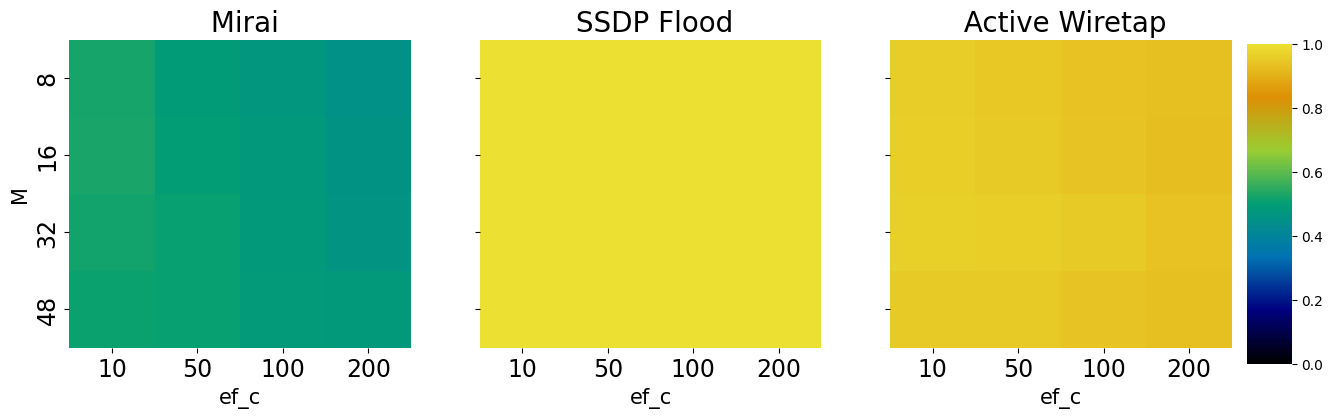

In [33]:
plot_df = eval_kitsuneWBKNN_df
f, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 4))
cbar_ax = f.add_axes([.91, 0.07, 0.03, .8])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    to_plot = plot_df[(plot_df.dataset == dataset)]
    AUCROC_means = to_plot[['M', 'ef_c', 'ROCAUC']].pivot_table(index="M", columns="ef_c", values="ROCAUC")
    # print(AUCROC_means)
    sns.heatmap(AUCROC_means, vmax=1, vmin=0, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 2, cbar_ax=None if i != 2 else cbar_ax)
    
    
    # Set axis titles and font sizes for bottom row
    axes.flat[i].set_title(f"{dataset.split('_')[0].split('.')[0][7:]}", fontsize=20) # , k={k}, ef_c = {ef_c}
    
    axes.flat[i].set_xlabel("ef_c", fontsize=15)
        
    if i%3 == 0:
        axes.flat[i].set_ylabel("M", fontsize=15)
    else:
        axes.flat[i].set_ylabel("")

    # Set tick label font size
    axes.flat[i].tick_params(axis='both', which='major', labelsize=17)


plt.show()

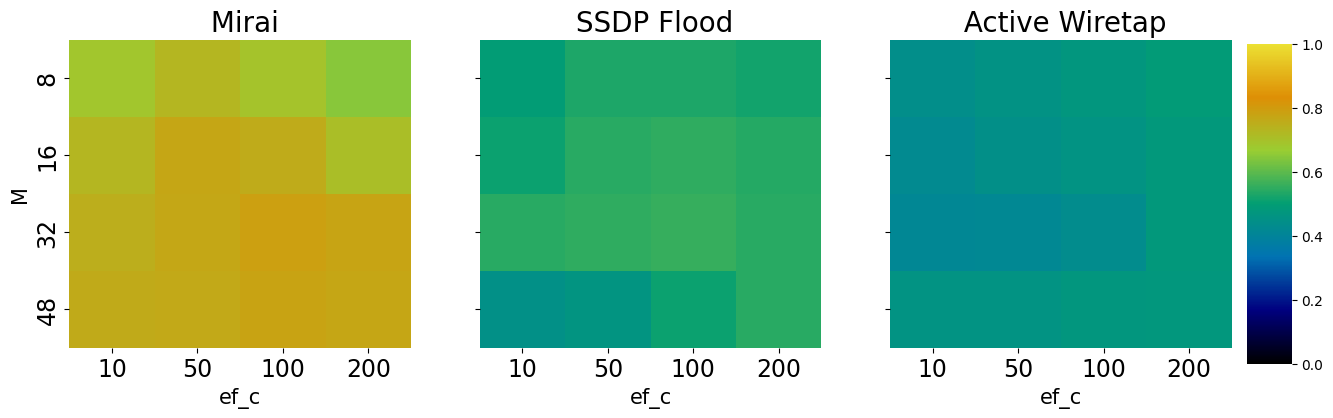

In [34]:
plot_df = eval_kitsuneWBLOF_df
f, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 4))
cbar_ax = f.add_axes([.91, 0.07, 0.03, .8])

for i, dataset in enumerate(set(plot_df['dataset'].values)):
    to_plot = plot_df[(plot_df.dataset == dataset)]
    AUCROC_means = to_plot[['M', 'ef_c', 'ROCAUC']].pivot_table(index="M", columns="ef_c", values="ROCAUC")
    # print(AUCROC_means)
    sns.heatmap(AUCROC_means, vmax=1, vmin=0, ax=axes.flat[i], cmap=custom_cmap, cbar = i == 2, cbar_ax=None if i != 2 else cbar_ax)
    
    
    # Set axis titles and font sizes for bottom row
    axes.flat[i].set_title(f"{dataset.split('_')[0].split('.')[0][7:]}", fontsize=20) # , k={k}, ef_c = {ef_c}
    
    axes.flat[i].set_xlabel("ef_c", fontsize=15)
        
    if i%3 == 0:
        axes.flat[i].set_ylabel("M", fontsize=15)
    else:
        axes.flat[i].set_ylabel("")

    # Set tick label font size
    axes.flat[i].tick_params(axis='both', which='major', labelsize=17)


plt.show()

# Quality of Approximate Neighborhoods

## Blackbox methods

In [35]:
df = pd.read_csv('../results/results_recall_blackbox.csv')
df = df[df.dataset.isin(interesting_datasets)]
print(df)
df[['dataset', 'M', 'ef_c', 'ef_s', 'recall']][df.recall < 0.95].groupby(['dataset', 'M', 'ef_c']).max().sort_values('dataset')

           dataset   M  ef_c  ef_s    k  recall.25    recall  recall.75
1152   25_musk.npz   8    10     8   15   0.466667  0.654104   0.933333
1153   25_musk.npz   8    10    16   15   0.466667  0.654104   0.933333
1154   25_musk.npz   8    10    32   15   0.533333  0.687350   0.933333
1155   25_musk.npz   8    10    48   15   0.533333  0.711866   1.000000
1156   25_musk.npz   8    10    64   15   0.600000  0.723100   1.000000
...            ...  ..   ...   ...  ...        ...       ...        ...
5749  9_census.npz  48   200    16  100   0.990000  0.990763   1.000000
5750  9_census.npz  48   200    32  100   0.990000  0.990763   1.000000
5751  9_census.npz  48   200    48  100   0.990000  0.990763   1.000000
5752  9_census.npz  48   200    64  100   0.990000  0.990763   1.000000
5753  9_census.npz  48   200   128  100   0.990000  0.992070   1.000000

[4602 rows x 8 columns]


ef_s    recall
dataset            M  ef_c                
10_cover.npz       8  10     128  0.584715
                      50     128  0.914580
                      100    128  0.944995
                   16 10     128  0.674259
                      50     128  0.909658
                      100     16  0.946047
                   32 10     128  0.881756
                      50     128  0.949598
                   48 10     128  0.926499
                      50     128  0.948538
13_fraud.npz       48 50      48  0.942559
                      10      64  0.949172
                   32 50      48  0.949904
                      10     128  0.943810
                   16 50      48  0.948864
                   8  200     16  0.948859
                      100     16  0.934628
                      50     128  0.945660
                      10     128  0.487533
                   16 10     128  0.742628
17_InternetAds.npz 32 50     128  0.833255
                   48 200    128  0.839283
                      100    128  0.851368
                      50     128  0.849944
                      10     128  0.847579
                   32 200    128  0.845148
                      100    128  0.842218
                      10     128  0.838240
                   16 200    128  0.825280
                      100    128  0.813418
                      50     128  0.785839
                      10     128  0.744476
                   8  200    128  0.776602
                      100    128  0.766395
                      50     128  0.736104
                      10     128  0.514619
1_ALOI.npz         32 200     16  0.943933
                   16 200     16  0.934800
                      10      16  0.948750
                   48 200     16  0.949302
                   8  100     16  0.930226
                      10     128  0.904122
                      200     32  0.939022
24_mnist.npz       8  10      64  0.947337
                   16 10      32  0.949020
25_musk.npz        8  10     128  0.752689
                   16 10     128  0.926736
                   32 10     128  0.895807
36_speech.npz      32 50      48  0.945339
                   48 200     16  0.914234
                      100     16  0.948761
                      50      48  0.949756
                      10      32  0.945650
                   32 200     32  0.945216
                      100     32  0.946012
                      10      64  0.949832
                   8  100    128  0.938262
                   16 100     64  0.949231
                      50      64  0.943030
                      10     128  0.939727
                   8  200    128  0.942774
                   16 200     64  0.946571
                   8  50     128  0.925203
                      10     128  0.856647
3_backdoor.npz     48 50     128  0.945734
                      10     128  0.949286
                   32 100     16  0.939697
                      10     128  0.916047
                      50     128  0.945055
                   16 10     128  0.879500
                   8  100     16  0.939796
                      50     128  0.948729
                      10     128  0.708842
                   16 50     128  0.941826
5_campaign.npz     8  10     128  0.819774
                   16 10     128  0.931347
8_celeba.npz       32 50     128  0.758776
                   48 100    128  0.763084
                      50     128  0.761671
                      10     128  0.761615
                      200    128  0.761234
                   32 200    128  0.755335
                      100    128  0.758377
                      10     128  0.757993
                   8  200    128  0.735695
                   16 100    128  0.745262
                      50     128  0.747472
                      10     128  0.741312
                   8  100    128  0.735369
                      50     128  0.734920
                      10     128  0.700583
                   16 200    

In [36]:
df[(df.dataset == "25_musk.npz") & (df.M == 40)].sort_values('recall')

,dataset,M,ef_c,ef_s,k,recall.25,recall,recall.75


## Question: Does bad recall give a bad ROCAUC?

<Axes: xlabel='dataset'>

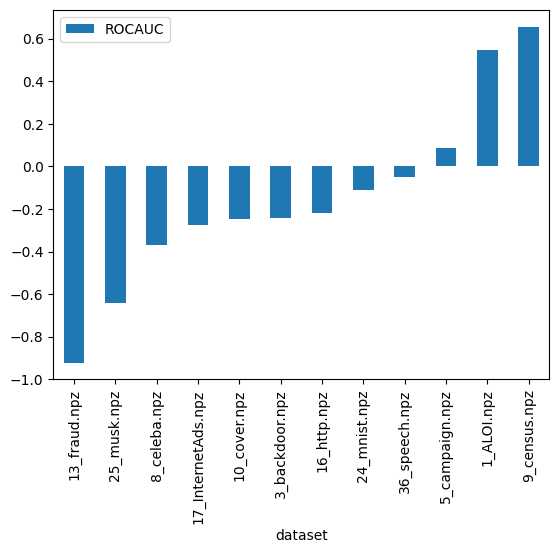

In [37]:
roc_df = pd.read_csv('../results/results_blackbox.csv')
roc_df = roc_df[roc_df.dataset.isin(interesting_datasets)]
eval_df = df.merge(roc_df, on=['dataset', 'M', 'ef_s', 'ef_c', 'k'])
corr_df = eval_df.groupby('dataset')[['recall', 'ROCAUC']].corr().reset_index()
corr_df[corr_df.level_1 == 'recall'][['dataset', 'ROCAUC']].sort_values('ROCAUC').plot.bar(x="dataset")

<Axes: xlabel='dataset'>

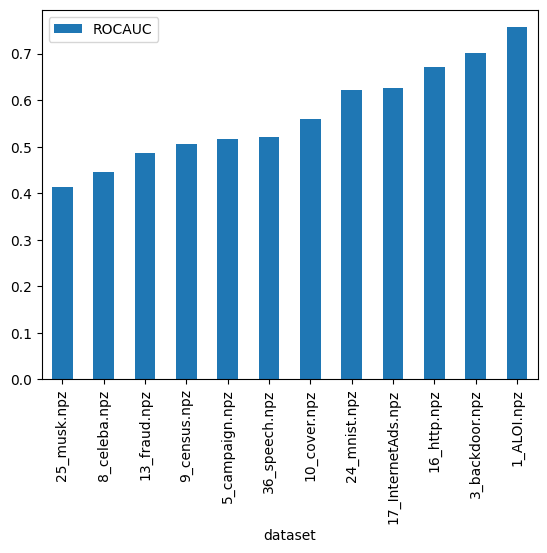

In [38]:
roc_df = pd.read_csv('../results/results_baselines.csv')
roc_df = roc_df[roc_df.dataset.isin(interesting_datasets)]
roc_df[(roc_df.variant == 'LOF') & (roc_df.k == 15)][['dataset', 'ROCAUC']].sort_values('ROCAUC').plot.bar(x="dataset")

# Kitsune (running time analysis)

In [3]:
df_black = pd.read_csv('../results/results_blackbox_kitsune.csv')
df_white = pd.read_csv('../results/results_whitebox_kitsune.csv')
df_white['variant'] = df_white['variant'].replace('contrast=False', 'KNN').replace('contrast=True', 'LOF')
#df_black['ef_c'] = df_black['ef_c'].replace(400, 200) # remove after experiments ran through.

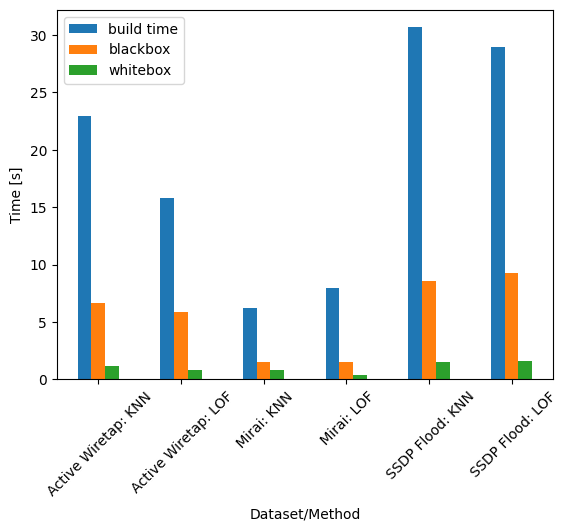

In [4]:
df = df_black.merge(df_white, on=['dataset', 'ef_c', 'M', 'variant'])
df['dataset'] = df['dataset'].replace('Kitsune ', ' ', regex=True).replace('_NoDup.npz', '', regex=True)
df['roc_diff'] = df['ROCAUC_x'] - df['ROCAUC_y']
df['speedup'] = df['time_detect_x'] / df['time_detect_y']

best_performance = df.groupby(['dataset', 'variant']).max().reset_index()[['dataset', 'variant', 'ROCAUC_x', 'ROCAUC_y']].rename(columns={'ROCAUC_x': 'best_roc_x', 'ROCAUC_y': 'best_roc_y'})

df = df.merge(best_performance, on=["dataset", "variant"])
#df
#plot_df = df[(df.roc_diff < 0.05) & (df.best_roc_x - df['ROCAUC_x'] < .2 * df.best_roc_x)].groupby(['dataset', 'variant']).mean().reset_index()
plot_df = df[(df.roc_diff < 0.05) & (df.best_roc_x - df['ROCAUC_x'] < .2 * df.best_roc_x)].sort_values('speedup', ascending=True).drop_duplicates(["dataset", "variant"])[["dataset", "variant", "time_build_x", "time_detect_x", "time_detect_y", "speedup"]].sort_values(["dataset", "variant"])


plot_df['label'] = plot_df['dataset'] + ": " + plot_df['variant']
ax = plot_df[['label', 'time_build_x', 'time_detect_x', 'time_detect_y', ]].rename(columns={"time_detect_x": "blackbox", "time_detect_y": "whitebox", "time_build_x": "build time"}).plot.bar(rot=45, x='label')
# for container in ax.containers:
#     ax.bar_label(container)
plt.ylabel("Time [s]")
plt.xlabel("Dataset/Method")
plt.show()
#axes[1].legend(loc=2)  

#plot_df